In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [14]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [10]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.3'

## MNAR LR 1:2

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 16:54:03.987 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 16:54:03.988 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 16:54:46.424 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 16:54:46.425 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 16:55:34.195 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 16:55:34.196 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 16:56:20.965 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 16:56:20.966 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

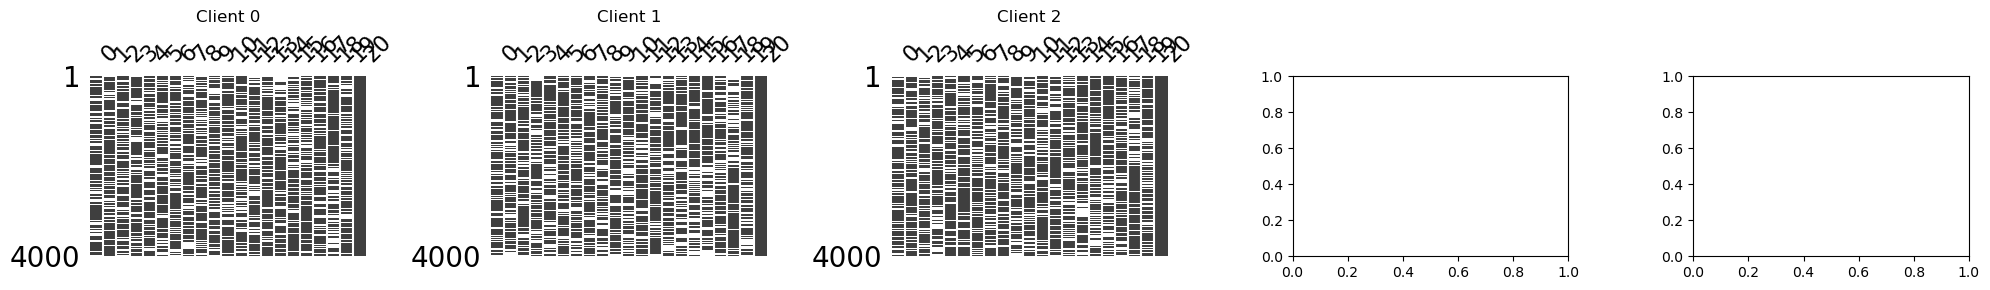

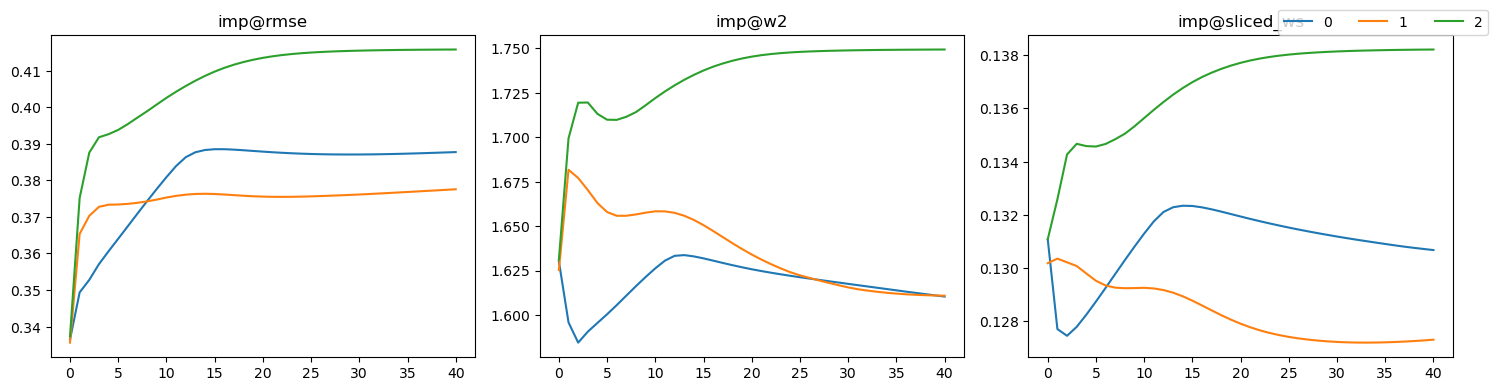

{'imp@rmse': 0.39354048096494176, 'imp@ws': 1.6574166550103608, 'imp@sliced_ws': 0.1320771292085561}


In [12]:
name = 'mnar_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [15]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-22 17:00:37.770 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7123, test_f1: 0.7121, val_loss: 0.6063, val_accu: 0.6692, val_f1: 0.6685
2023-07-22 17:01:46.323 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7188, test_f1: 0.7186, val_loss: 0.6105, val_accu: 0.6804, val_f1: 0.6789
2023-07-22 17:02:55.840 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7194, test_f1: 0.7190, val_loss: 0.6035, val_accu: 0.6837, val_f1: 0.6821
2023-07-22 17:04:05.434 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7076, test_f1: 0.7067, val_loss: 0.5877, val_accu: 0.6900, val_f1: 0.6881
2023-07-22 17:05:15.334 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6966, test_f1: 0.694

0.7247307935933399


In [16]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 17:09:48.008 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5318, train_loss: 0.6932 val_accu: 0.5117 val_f1: 0.3806
2023-07-22 17:10:14.529 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8174, train_loss: 0.5477 val_accu: 0.7183 val_f1: 0.7178
2023-07-22 17:10:41.183 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7829, train_loss: 0.5228 val_accu: 0.7342 val_f1: 0.7330
2023-07-22 17:11:08.140 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7563, train_loss: 0.5076 val_accu: 0.7346 val_f1: 0.7316
2023-07-22 17:11:34.862 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7638, train_loss: 0.4992 val_accu: 0.7475 val_f1: 0.7475


0.8185684553434078


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 17:12:17.148 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:12:17.149 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 17:13:09.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:13:09.892 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 17:13:56.403 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:13:56.404 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 17:14:42.777 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:14:42.778 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

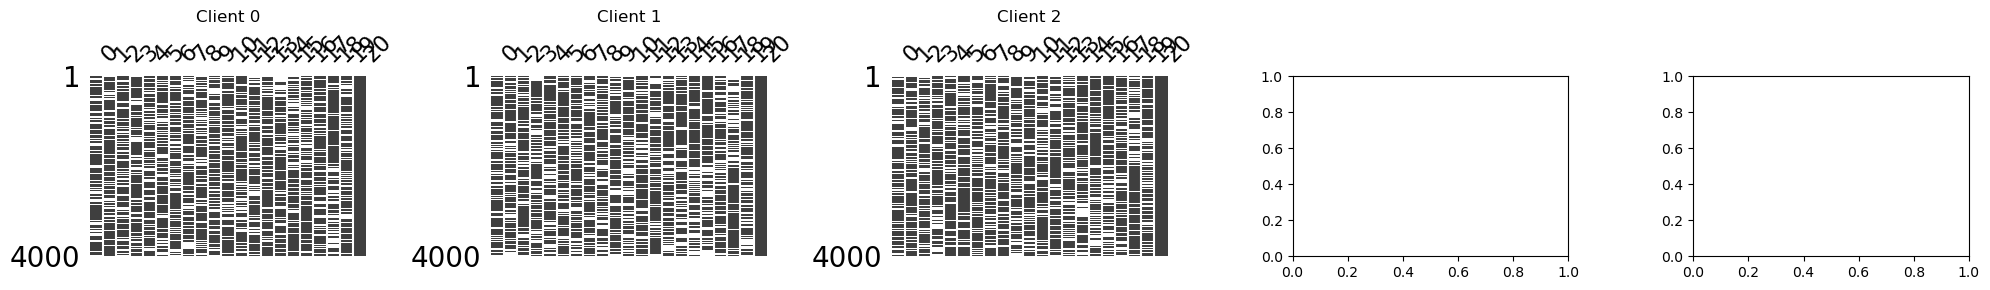

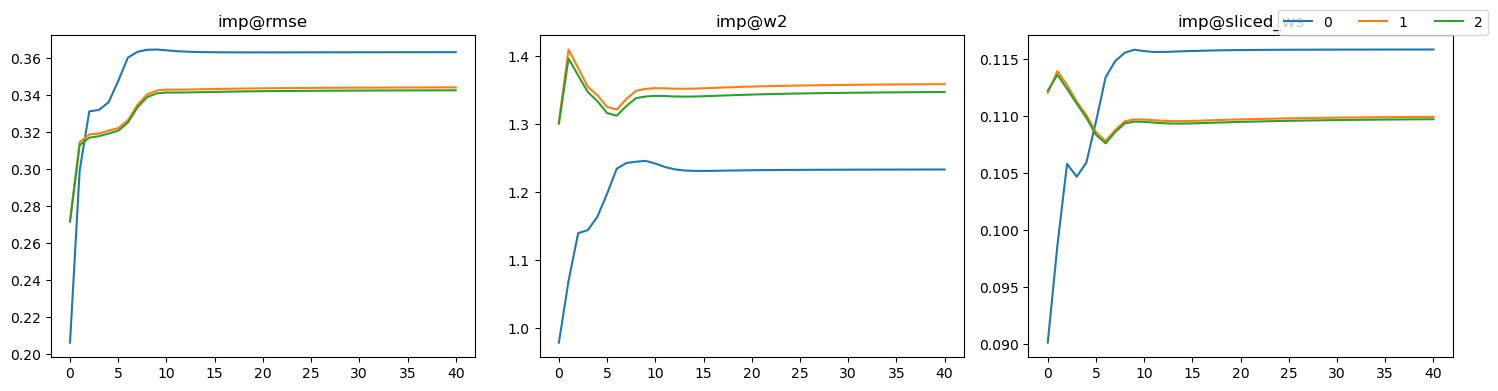

{'imp@rmse': 0.34970215337184746, 'imp@ws': 1.3132485503446116, 'imp@sliced_ws': 0.11182724408505636}


In [17]:
name = 'mnar_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [50]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_savg'], type='fedavg', n_rounds=500, server_config_tmpl=server_config_tmpl)

2023-07-22 21:34:31.645 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7882, test_f1: 0.7867, val_loss: 0.5155, val_accu: 0.7442, val_f1: 0.7428
2023-07-22 21:35:33.572 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7923, test_f1: 0.7912, val_loss: 0.5099, val_accu: 0.7529, val_f1: 0.7501
2023-07-22 21:36:36.064 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7979, test_f1: 0.7975, val_loss: 0.5081, val_accu: 0.7521, val_f1: 0.7505
2023-07-22 21:37:37.226 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8086, test_f1: 0.8086, val_loss: 0.5392, val_accu: 0.7396, val_f1: 0.7366
2023-07-22 21:38:39.618 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8215, test_f1: 0.821

0.8222785268301511


In [19]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 17:15:35.431 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5395, train_loss: 0.6930 val_accu: 0.5292 val_f1: 0.4460
2023-07-22 17:16:01.730 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7879, train_loss: 0.5110 val_accu: 0.7342 val_f1: 0.7331
2023-07-22 17:16:27.920 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7881, train_loss: 0.4930 val_accu: 0.7692 val_f1: 0.7667
2023-07-22 17:16:54.369 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7758, train_loss: 0.4709 val_accu: 0.7788 val_f1: 0.7760
2023-07-22 17:17:21.124 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7655, train_loss: 0.4537 val_accu: 0.7917 val_f1: 0.7916


0.8070762826893494


### Our

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 17:18:03.325 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:18:03.326 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 17:18:46.456 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:18:46.457 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 17:19:34.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:19:34.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 17:20:21.193 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:20:21.194 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

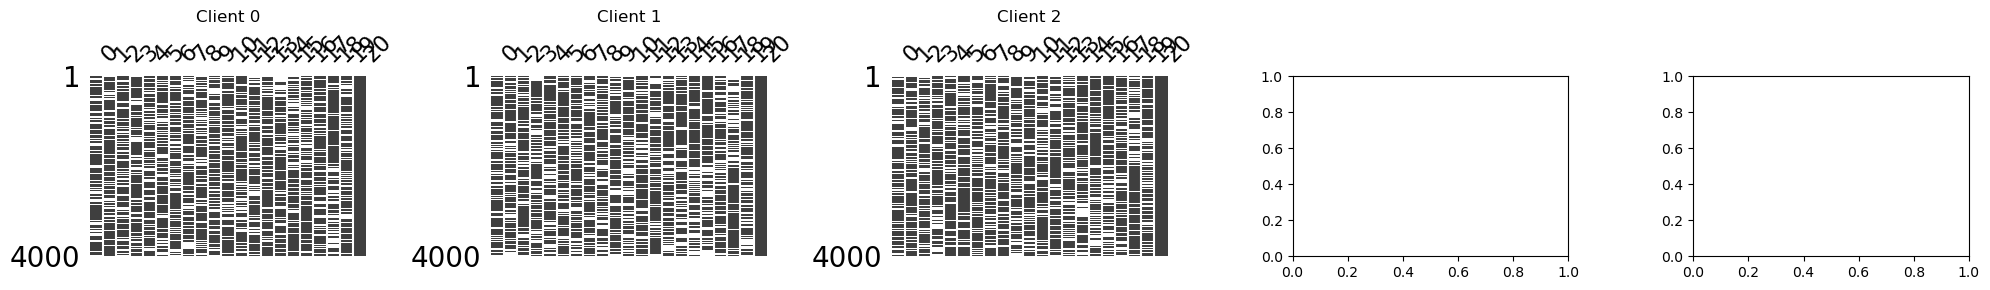

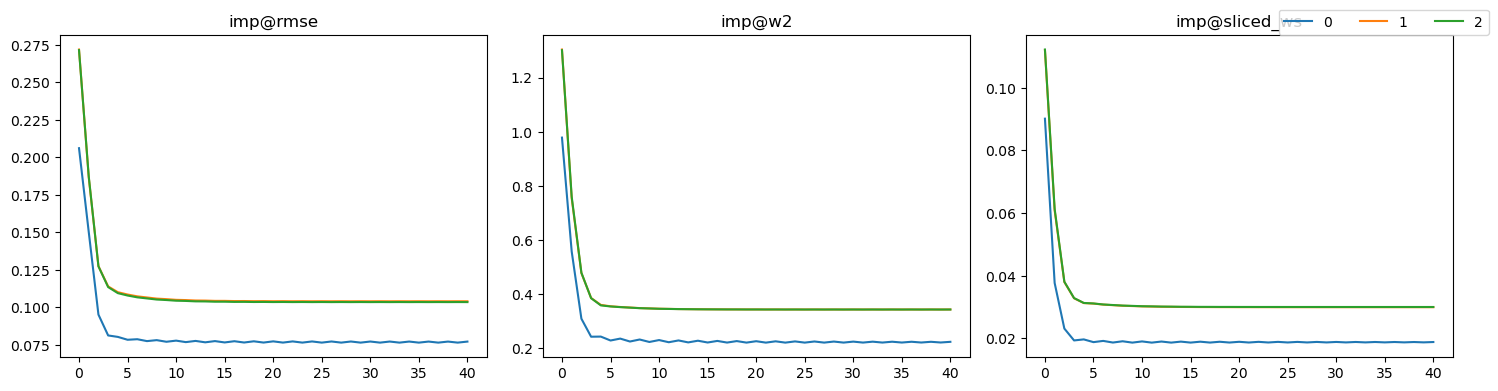

{'imp@rmse': 0.09487025924859957, 'imp@ws': 0.3029445701923202, 'imp@sliced_ws': 0.02627294627161556}


In [20]:
name = 'mnar_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [21]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 17:22:22.757 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8882, test_f1: 0.8882, val_loss: 0.3915, val_accu: 0.8392, val_f1: 0.8391
2023-07-22 17:23:30.981 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8991, test_f1: 0.8991, val_loss: 0.3676, val_accu: 0.8475, val_f1: 0.8475
2023-07-22 17:24:39.405 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9048, test_f1: 0.9048, val_loss: 0.3550, val_accu: 0.8546, val_f1: 0.8546
2023-07-22 17:25:47.418 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9098, test_f1: 0.9098, val_loss: 0.3468, val_accu: 0.8562, val_f1: 0.8562
2023-07-22 17:26:57.328 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9107, test_f1: 0.910

0.9144873767079902


In [22]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 17:32:27.754 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5371, train_loss: 0.6927 val_accu: 0.5133 val_f1: 0.4545
2023-07-22 17:32:52.429 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8913, train_loss: 0.3784 val_accu: 0.8525 val_f1: 0.8524
2023-07-22 17:33:17.560 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.9007, train_loss: 0.3453 val_accu: 0.8475 val_f1: 0.8464
2023-07-22 17:33:42.544 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9096, train_loss: 0.3124 val_accu: 0.8704 val_f1: 0.8702
2023-07-22 17:34:07.807 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9126, train_loss: 0.3005 val_accu: 0.8717 val_f1: 0.8717


0.9172020631617048


## MNAR LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 17:34:48.241 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:34:48.242 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 17:35:34.604 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:35:34.605 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 17:36:20.602 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:36:20.602 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 17:37:07.149 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:37:07.150 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

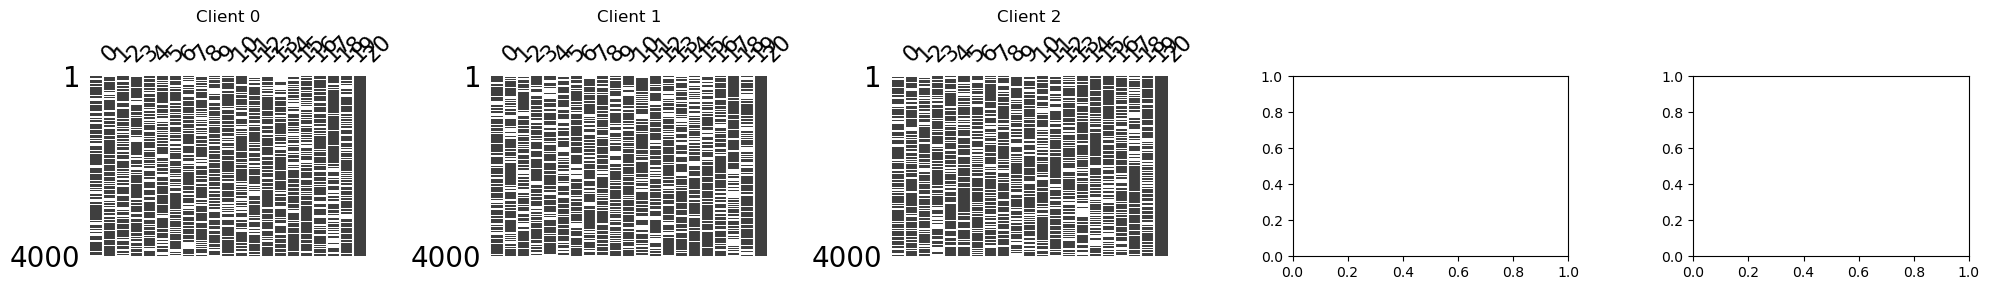

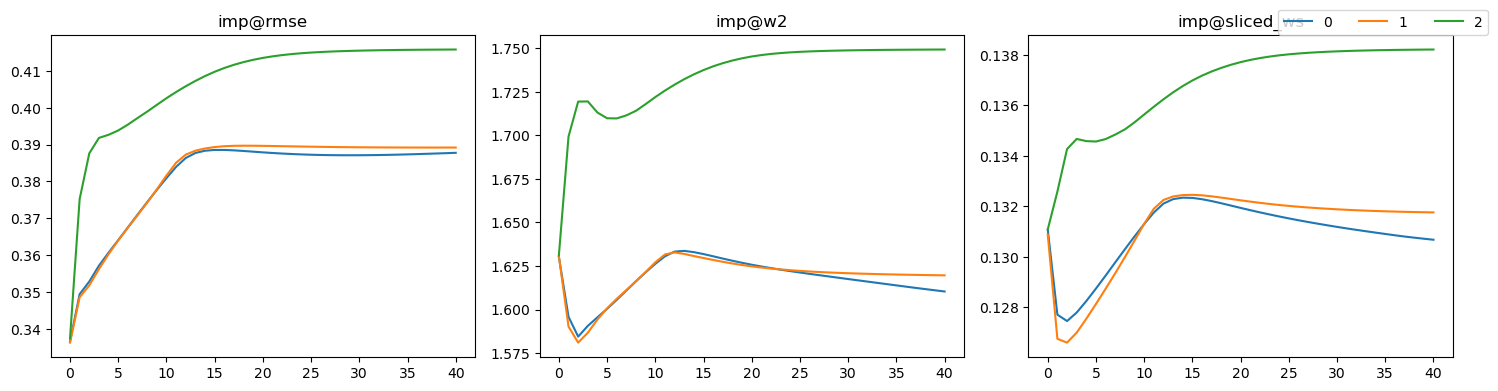

{'imp@rmse': 0.3975092292511096, 'imp@ws': 1.6602911891650953, 'imp@sliced_ws': 0.13358023562428262}


In [23]:
name = 'mnar_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [24]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 17:39:05.127 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6753, test_f1: 0.6733, val_loss: 0.7064, val_accu: 0.6112, val_f1: 0.6048
2023-07-22 17:40:10.007 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6663, test_f1: 0.6640, val_loss: 0.8234, val_accu: 0.5850, val_f1: 0.5776
2023-07-22 17:41:15.786 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6502, test_f1: 0.6464, val_loss: 0.9690, val_accu: 0.5596, val_f1: 0.5507
2023-07-22 17:42:31.091 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6403, test_f1: 0.6354, val_loss: 1.0632, val_accu: 0.5517, val_f1: 0.5427
2023-07-22 17:43:41.131 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6390, test_f1: 0.634

0.6764093747172202


In [25]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 17:48:17.430 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5186, train_loss: 0.6930 val_accu: 0.5167 val_f1: 0.4126
2023-07-22 17:48:42.569 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7064, train_loss: 0.5426 val_accu: 0.7362 val_f1: 0.7362
2023-07-22 17:49:08.058 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6878, train_loss: 0.5183 val_accu: 0.7146 val_f1: 0.7065
2023-07-22 17:49:33.133 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6751, train_loss: 0.5034 val_accu: 0.7417 val_f1: 0.7378
2023-07-22 17:49:58.735 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6725, train_loss: 0.4904 val_accu: 0.7504 val_f1: 0.7497


0.7263596054655688


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 17:50:40.289 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:50:40.290 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 17:51:31.953 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:51:31.954 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 17:52:19.213 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:52:19.214 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 17:53:05.716 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 17:53:05.717 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

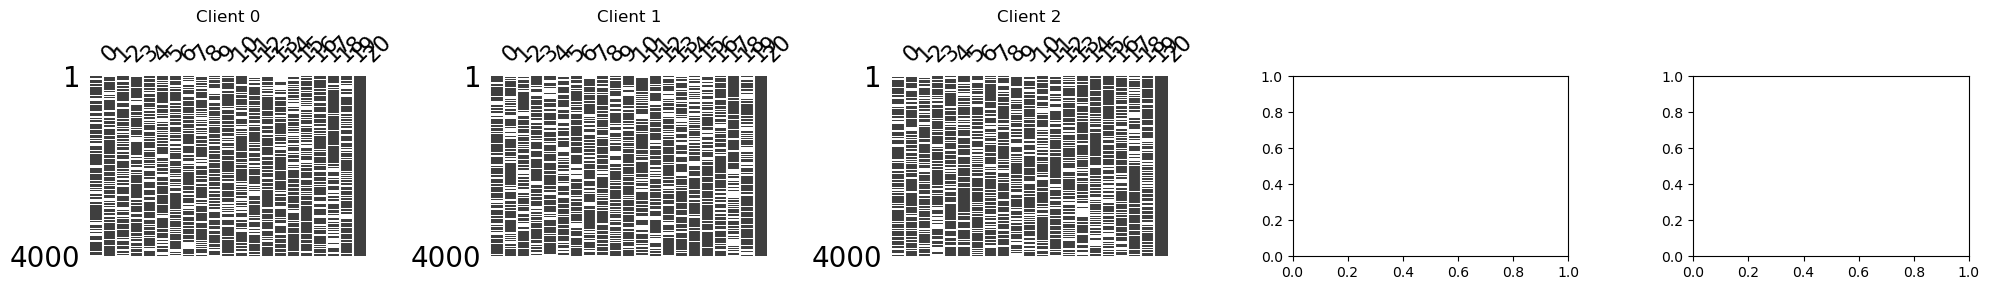

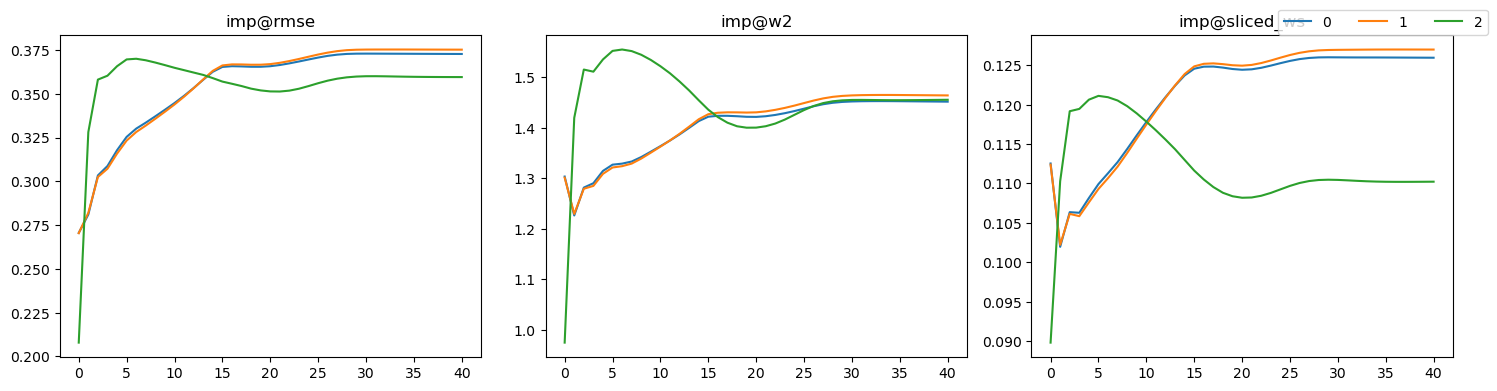

{'imp@rmse': 0.3691519591625608, 'imp@ws': 1.4571583253718863, 'imp@sliced_ws': 0.12105581334886915}


In [26]:
name = 'mnar_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [27]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_savg'], type='fedavg', n_rounds=500,server_config_tmpl = server_config_tmpl)

2023-07-22 17:55:00.958 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7860, test_f1: 0.7860, val_loss: 0.5312, val_accu: 0.7383, val_f1: 0.7377
2023-07-22 17:56:03.562 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7431, test_f1: 0.7429, val_loss: 0.5159, val_accu: 0.7492, val_f1: 0.7489
2023-07-22 17:57:06.673 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7102, test_f1: 0.7097, val_loss: 0.4954, val_accu: 0.7521, val_f1: 0.7521
2023-07-22 17:58:09.699 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7011, test_f1: 0.7006, val_loss: 0.4874, val_accu: 0.7558, val_f1: 0.7558
2023-07-22 17:59:12.502 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6859, test_f1: 0.685

0.8134105510813501


In [28]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:03:27.192 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5228, train_loss: 0.6926 val_accu: 0.5208 val_f1: 0.4639
2023-07-22 18:03:50.934 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7769, train_loss: 0.5182 val_accu: 0.7504 val_f1: 0.7503
2023-07-22 18:04:14.567 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7607, train_loss: 0.4898 val_accu: 0.7421 val_f1: 0.7374
2023-07-22 18:04:38.547 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7424, train_loss: 0.4713 val_accu: 0.7654 val_f1: 0.7637
2023-07-22 18:05:02.663 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7148, train_loss: 0.4575 val_accu: 0.7754 val_f1: 0.7753


0.7977558591982626


### Our Models

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 18:05:41.320 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:05:41.321 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 18:06:27.250 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:06:27.251 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 18:07:14.234 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:07:14.235 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 18:08:00.280 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:08:00.281 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

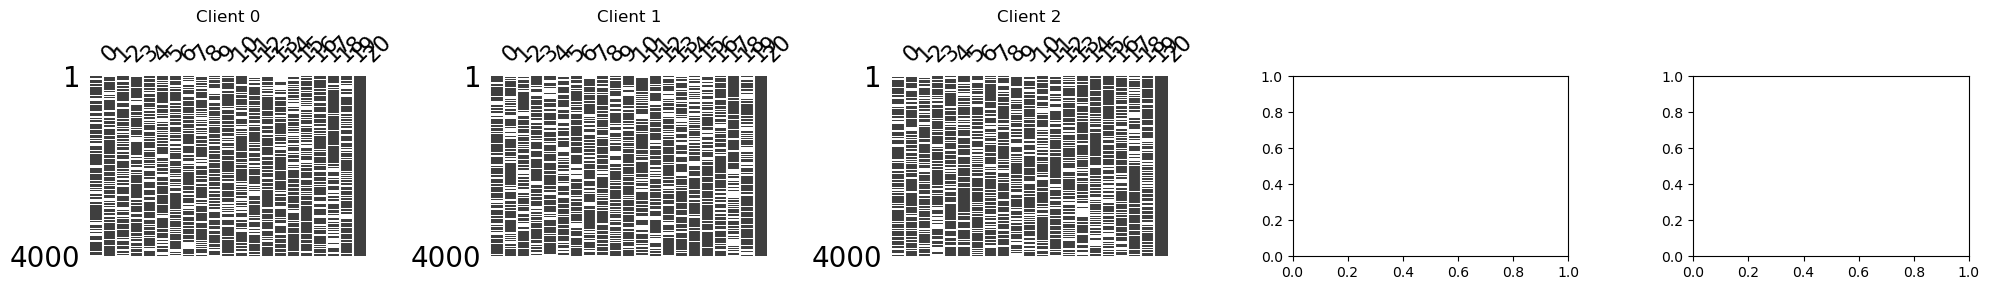

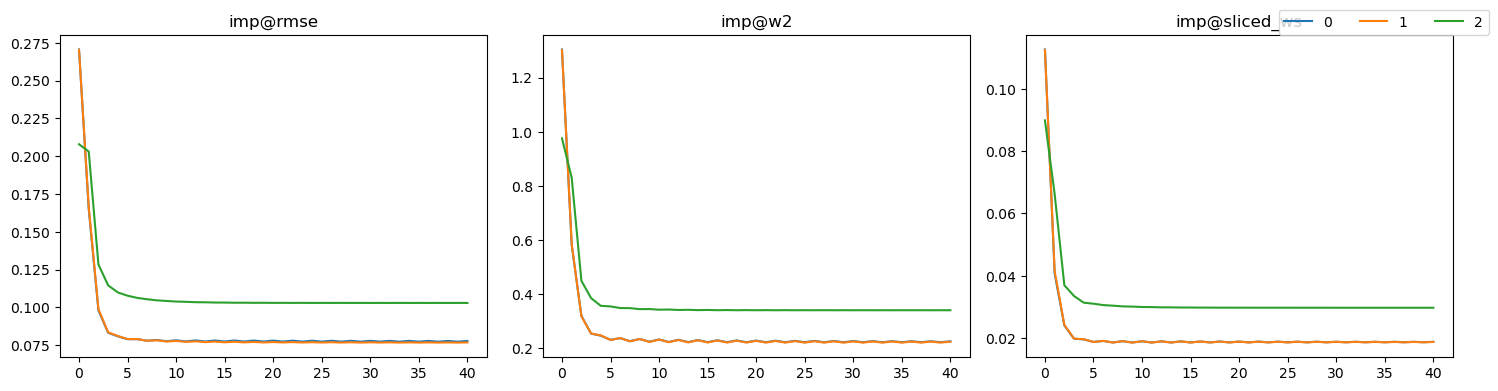

{'imp@rmse': 0.08575587140566777, 'imp@ws': 0.26193308179413877, 'imp@sliced_ws': 0.022364200757327268}


In [29]:
name = 'mnar_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [30]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:09:57.081 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8864, test_f1: 0.8864, val_loss: 0.3759, val_accu: 0.8475, val_f1: 0.8475
2023-07-22 18:11:01.376 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9006, test_f1: 0.9005, val_loss: 0.3516, val_accu: 0.8621, val_f1: 0.8621
2023-07-22 18:12:07.754 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9070, test_f1: 0.9069, val_loss: 0.3350, val_accu: 0.8688, val_f1: 0.8687
2023-07-22 18:13:13.318 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9093, test_f1: 0.9092, val_loss: 0.3238, val_accu: 0.8729, val_f1: 0.8729
2023-07-22 18:14:19.911 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9133, test_f1: 0.913

0.9181069586462763


In [31]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:19:50.630 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5450, train_loss: 0.6925 val_accu: 0.5167 val_f1: 0.4569
2023-07-22 18:20:14.491 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8903, train_loss: 0.3672 val_accu: 0.8558 val_f1: 0.8555
2023-07-22 18:20:38.899 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8969, train_loss: 0.3392 val_accu: 0.8588 val_f1: 0.8580
2023-07-22 18:21:03.748 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9072, train_loss: 0.3104 val_accu: 0.8729 val_f1: 0.8729
2023-07-22 18:21:28.157 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9113, train_loss: 0.3010 val_accu: 0.8829 val_f1: 0.8828


0.916749615419419


## MARY LR 1:2

### Local 

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.3', 'mary_sigmoid_right@0.3']
(11051, 21)


2023-07-22 18:22:07.836 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:22:07.837 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 18:22:53.193 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:22:53.194 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 18:23:37.802 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:23:37.803 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 18:24:22.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:24:22.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

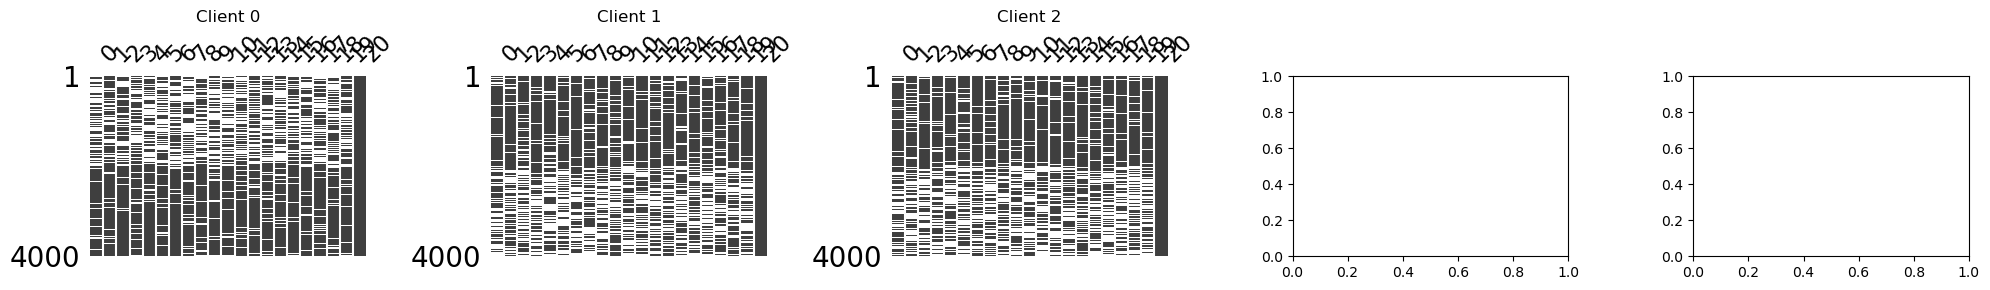

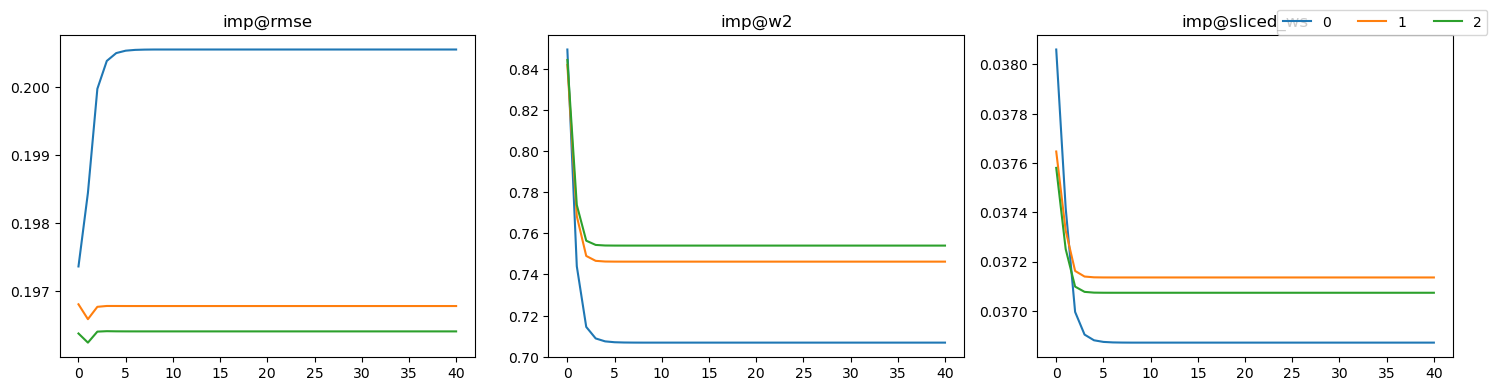

{'imp@rmse': 0.19791763744294094, 'imp@ws': 0.735706091099986, 'imp@sliced_ws': 0.03702657159184064}


In [32]:
name = 'mary_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [33]:
pred_ret = NN_evaluation(
    rets['mary_lr12_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:26:16.231 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8558, test_f1: 0.8541, val_loss: 0.6652, val_accu: 0.7021, val_f1: 0.6795
2023-07-22 18:27:20.670 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8744, test_f1: 0.8738, val_loss: 0.6605, val_accu: 0.7092, val_f1: 0.6905
2023-07-22 18:28:27.190 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8761, test_f1: 0.8756, val_loss: 0.6783, val_accu: 0.7033, val_f1: 0.6833
2023-07-22 18:29:33.924 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8775, test_f1: 0.8774, val_loss: 0.6795, val_accu: 0.7133, val_f1: 0.6962
2023-07-22 18:30:39.928 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8755, test_f1: 0.875

0.8843543570717582


In [34]:
pred_ret = NN_evaluation(
    rets['mary_lr12_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:36:20.182 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5214, train_loss: 0.6924 val_accu: 0.5029 val_f1: 0.3850
2023-07-22 18:36:43.850 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8386, train_loss: 0.4779 val_accu: 0.7708 val_f1: 0.7706
2023-07-22 18:37:07.680 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8920, train_loss: 0.4660 val_accu: 0.7775 val_f1: 0.7749
2023-07-22 18:37:36.093 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8802, train_loss: 0.4566 val_accu: 0.7775 val_f1: 0.7766
2023-07-22 18:38:03.276 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8812, train_loss: 0.4510 val_accu: 0.7804 val_f1: 0.7797


0.9071577232829608


### Simple Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.3', 'mary_sigmoid_right@0.3']
(11051, 21)


2023-07-22 18:38:48.055 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:38:48.055 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 18:39:40.964 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:39:40.965 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 18:40:28.485 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:40:28.486 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 18:41:13.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:41:13.166 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

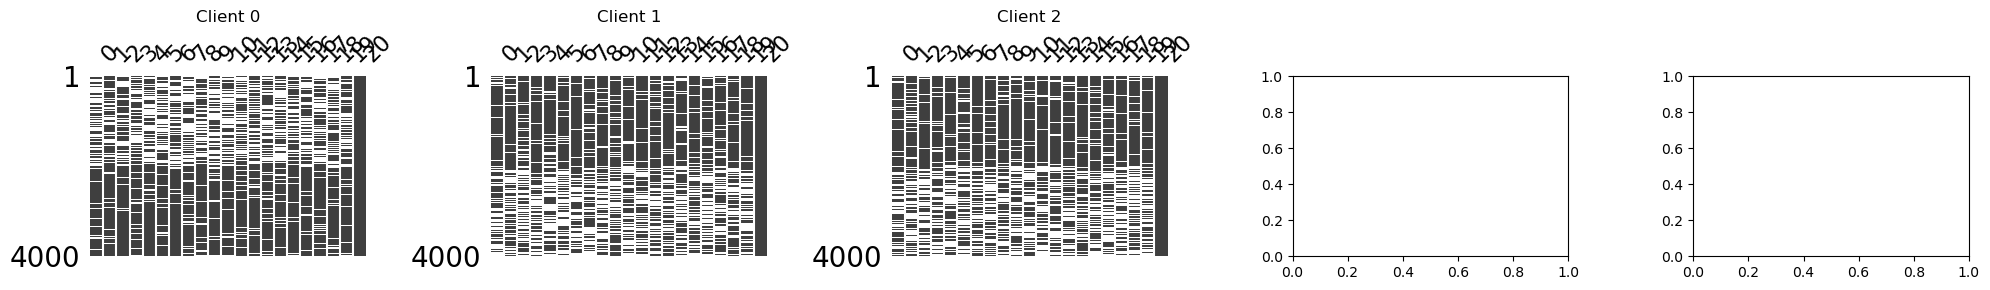

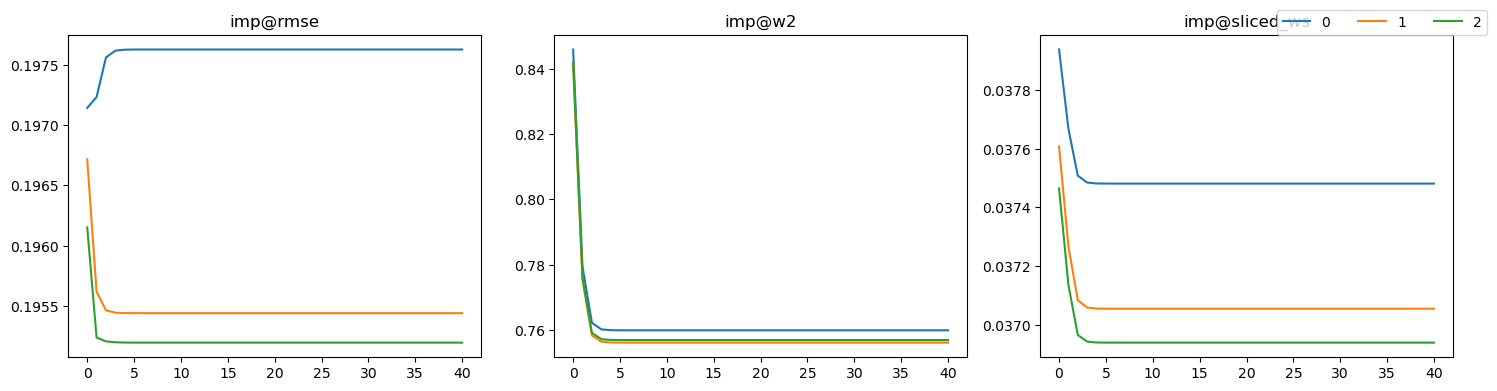

{'imp@rmse': 0.19608887472101877, 'imp@ws': 0.7575928747342271, 'imp@sliced_ws': 0.03715864491314181}


In [35]:
name = 'mary_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [36]:
pred_ret = NN_evaluation(
    rets['mary_lr12_savg'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:43:10.872 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8589, test_f1: 0.8573, val_loss: 0.6460, val_accu: 0.7125, val_f1: 0.6922
2023-07-22 18:44:15.434 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8747, test_f1: 0.8740, val_loss: 0.6637, val_accu: 0.7179, val_f1: 0.6988
2023-07-22 18:45:21.970 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8821, test_f1: 0.8821, val_loss: 0.6517, val_accu: 0.7317, val_f1: 0.7167
2023-07-22 18:46:28.460 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8604, test_f1: 0.8601, val_loss: 0.6172, val_accu: 0.7433, val_f1: 0.7332
2023-07-22 18:47:34.702 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8559, test_f1: 0.855

0.8868880644285585


In [37]:
pred_ret = NN_evaluation(
    rets['mary_lr12_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:52:07.493 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5345, train_loss: 0.6920 val_accu: 0.5158 val_f1: 0.3996
2023-07-22 18:52:31.860 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8678, train_loss: 0.4529 val_accu: 0.7879 val_f1: 0.7878
2023-07-22 18:52:56.902 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8957, train_loss: 0.4412 val_accu: 0.7867 val_f1: 0.7850
2023-07-22 18:53:21.971 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8840, train_loss: 0.4293 val_accu: 0.7942 val_f1: 0.7938
2023-07-22 18:53:46.726 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8876, train_loss: 0.4230 val_accu: 0.7933 val_f1: 0.7929


0.910234367930504


### Our Method

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.3', 'mary_sigmoid_right@0.3']
(11051, 21)


2023-07-22 18:54:28.897 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:54:28.898 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 18:55:16.289 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:55:16.290 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 18:56:02.147 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:56:02.148 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 18:56:48.106 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 18:56:48.107 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

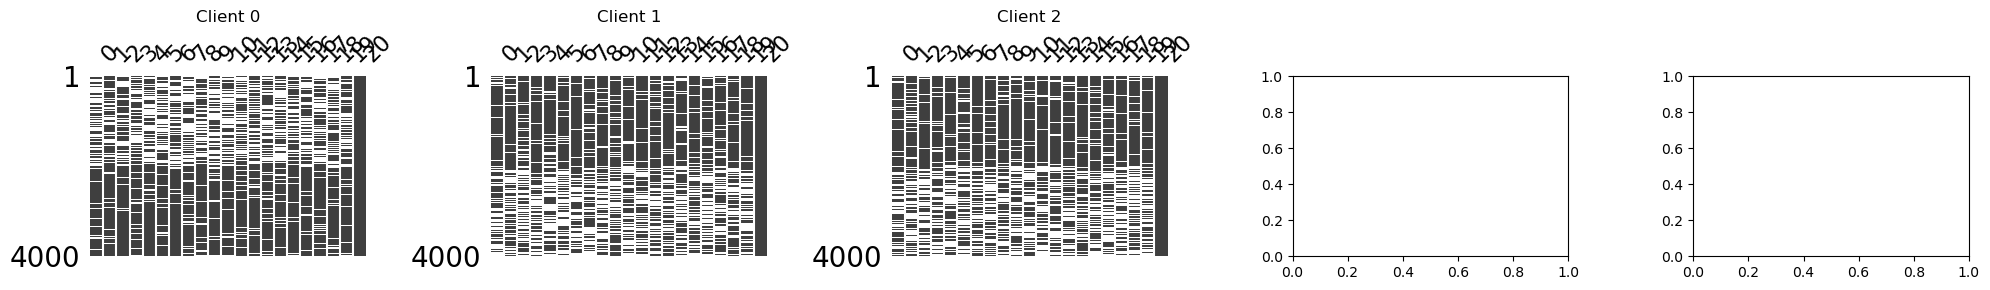

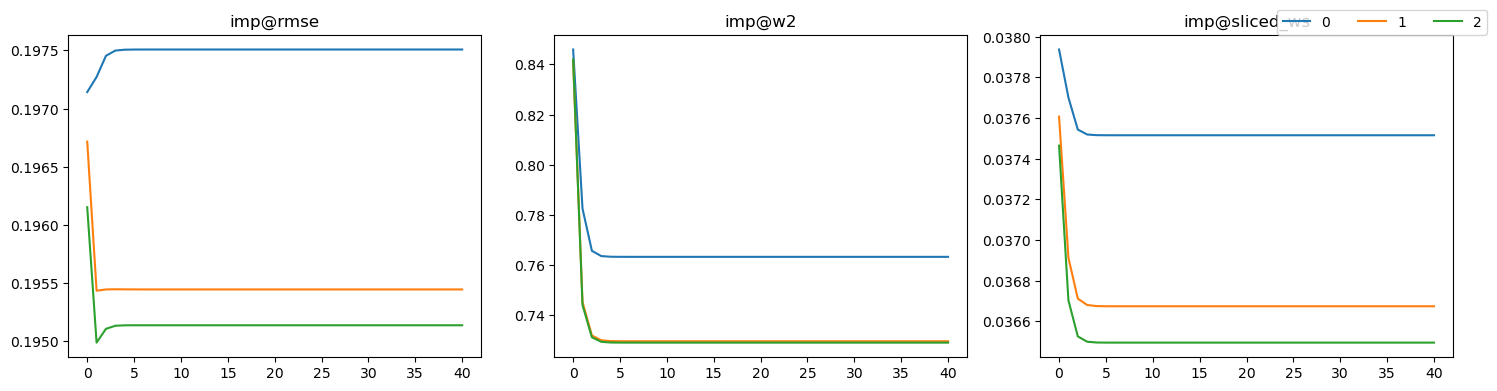

{'imp@rmse': 0.19603020290103274, 'imp@ws': 0.7406539613183953, 'imp@sliced_ws': 0.03689500329180022}


In [38]:
name = 'mary_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [39]:
pred_ret = NN_evaluation(
    rets['mary_lr12_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 18:58:49.284 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8765, test_f1: 0.8757, val_loss: 0.6071, val_accu: 0.7246, val_f1: 0.7077
2023-07-22 18:59:59.302 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8972, test_f1: 0.8970, val_loss: 0.5990, val_accu: 0.7342, val_f1: 0.7195
2023-07-22 19:01:15.205 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8735, test_f1: 0.8734, val_loss: 0.5644, val_accu: 0.7596, val_f1: 0.7513
2023-07-22 19:02:33.664 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8638, test_f1: 0.8635, val_loss: 0.5705, val_accu: 0.7583, val_f1: 0.7508
2023-07-22 19:03:45.593 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8459, test_f1: 0.844

0.8996470907610171


In [40]:
pred_ret = NN_evaluation(
    rets['mary_lr12_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:08:19.713 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5470, train_loss: 0.6918 val_accu: 0.5300 val_f1: 0.4288
2023-07-22 19:08:45.903 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8434, train_loss: 0.4225 val_accu: 0.8067 val_f1: 0.8065
2023-07-22 19:09:12.774 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8994, train_loss: 0.4091 val_accu: 0.8004 val_f1: 0.7980
2023-07-22 19:09:38.737 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9049, train_loss: 0.3924 val_accu: 0.8225 val_f1: 0.8223
2023-07-22 19:10:04.817 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9085, train_loss: 0.3828 val_accu: 0.8192 val_f1: 0.8188


0.9176545109039906


## MARY LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.3']
(11051, 21)


2023-07-22 19:10:48.980 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:10:48.981 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 19:11:42.034 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:11:42.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 19:12:29.760 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:12:29.760 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 19:13:18.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:13:18.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

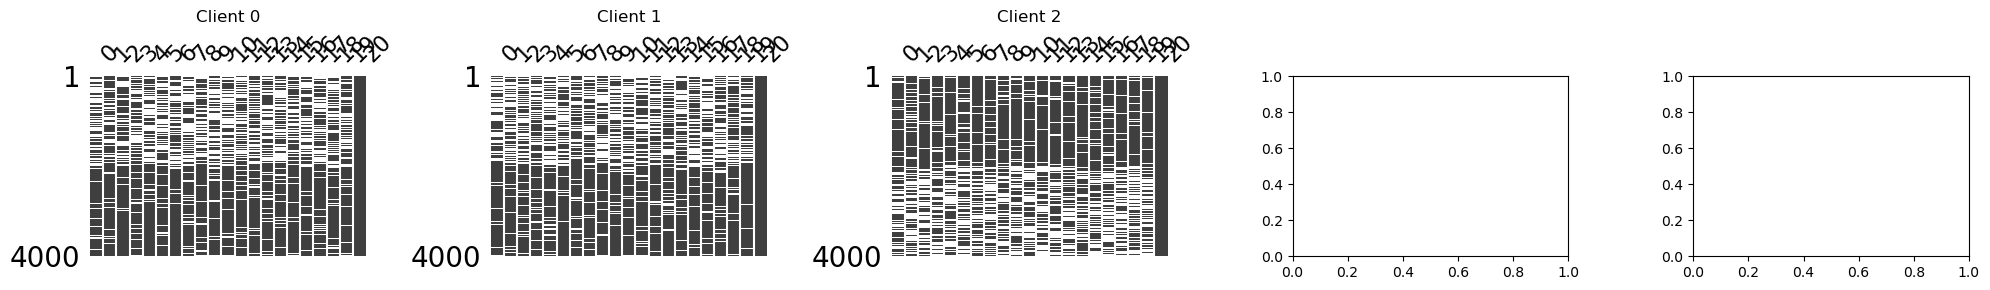

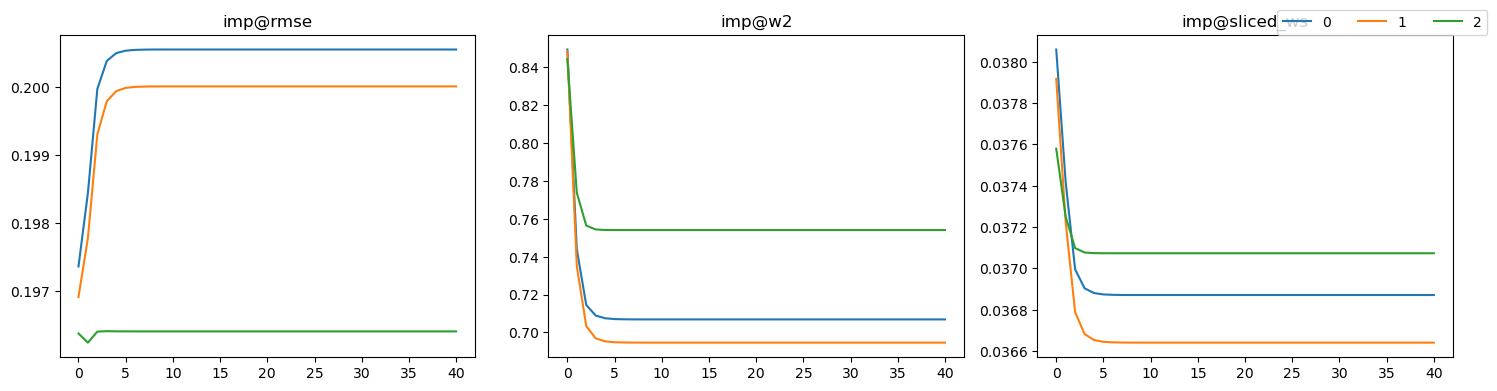

{'imp@rmse': 0.1989940209387075, 'imp@ws': 0.7185002198620523, 'imp@sliced_ws': 0.036861620564550134}


In [41]:
name = 'mary_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [42]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:15:17.994 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8519, test_f1: 0.8518, val_loss: 0.6270, val_accu: 0.7321, val_f1: 0.7245
2023-07-22 19:16:30.839 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8473, test_f1: 0.8470, val_loss: 0.6490, val_accu: 0.7304, val_f1: 0.7217
2023-07-22 19:17:45.688 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8545, test_f1: 0.8539, val_loss: 0.6321, val_accu: 0.7425, val_f1: 0.7349
2023-07-22 19:18:58.931 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8625, test_f1: 0.8618, val_loss: 0.6253, val_accu: 0.7471, val_f1: 0.7404
2023-07-22 19:20:12.337 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8632, test_f1: 0.862

0.8911410732060447


In [43]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:25:57.717 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5263, train_loss: 0.6925 val_accu: 0.5200 val_f1: 0.4221
2023-07-22 19:26:23.146 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8921, train_loss: 0.4753 val_accu: 0.7771 val_f1: 0.7768
2023-07-22 19:26:48.485 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8922, train_loss: 0.4686 val_accu: 0.7758 val_f1: 0.7757
2023-07-22 19:27:14.067 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8883, train_loss: 0.4538 val_accu: 0.7767 val_f1: 0.7767
2023-07-22 19:27:39.413 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8839, train_loss: 0.4464 val_accu: 0.7808 val_f1: 0.7808


0.9133110125780473


### Simpel Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.3']
(11051, 21)


2023-07-22 19:28:21.036 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:28:21.037 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 19:29:06.040 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:29:06.041 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 19:29:50.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:29:50.533 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 19:30:35.091 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:30:35.092 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

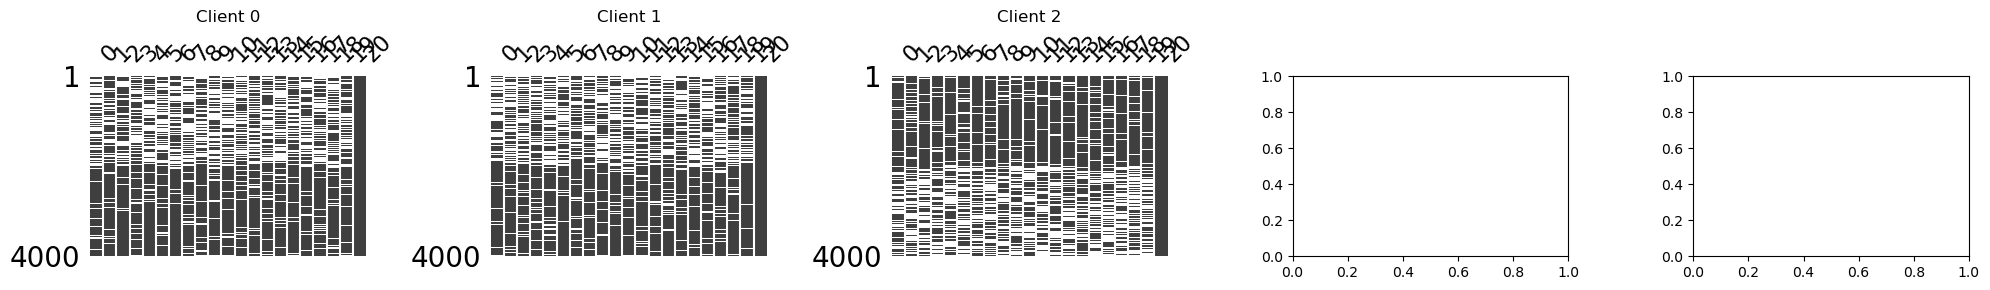

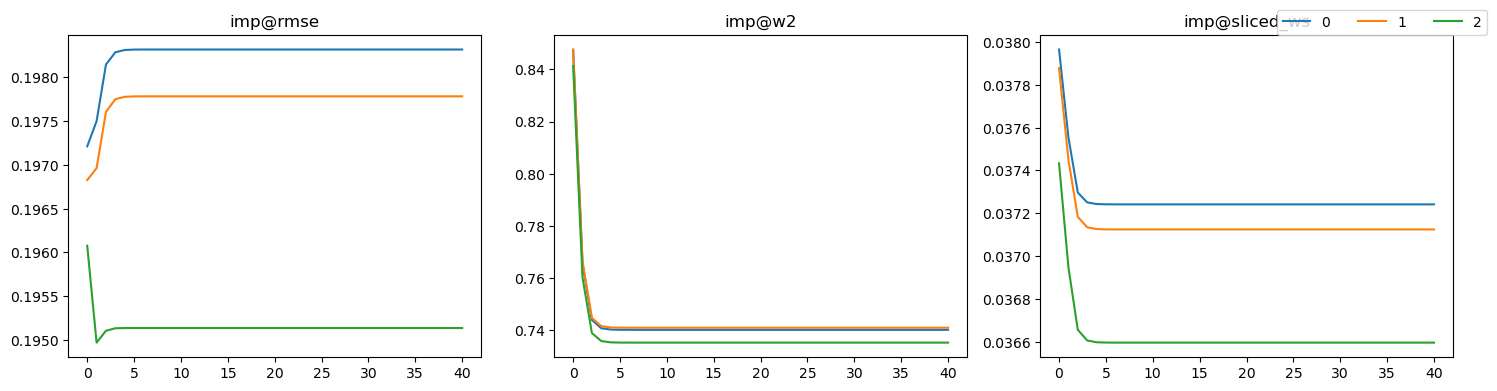

{'imp@rmse': 0.19707697320673848, 'imp@ws': 0.7388164415664934, 'imp@sliced_ws': 0.03698674970804636}


In [44]:
name = 'mary_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [45]:
pred_ret = NN_evaluation(
    rets['mary_lr21_savg'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:32:33.392 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8349, test_f1: 0.8339, val_loss: 0.5336, val_accu: 0.7646, val_f1: 0.7621
2023-07-22 19:33:40.787 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8242, test_f1: 0.8208, val_loss: 0.5220, val_accu: 0.7696, val_f1: 0.7681
2023-07-22 19:34:48.970 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8051, test_f1: 0.7995, val_loss: 0.5073, val_accu: 0.7721, val_f1: 0.7709
2023-07-22 19:35:56.950 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8084, test_f1: 0.8029, val_loss: 0.5074, val_accu: 0.7767, val_f1: 0.7755
2023-07-22 19:37:05.599 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8203, test_f1: 0.815

0.8562121075015836


In [46]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:42:46.608 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5263, train_loss: 0.6925 val_accu: 0.5200 val_f1: 0.4221
2023-07-22 19:43:10.405 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8921, train_loss: 0.4753 val_accu: 0.7771 val_f1: 0.7768
2023-07-22 19:43:35.956 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8922, train_loss: 0.4686 val_accu: 0.7758 val_f1: 0.7757
2023-07-22 19:44:01.293 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8883, train_loss: 0.4538 val_accu: 0.7767 val_f1: 0.7767
2023-07-22 19:44:26.897 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8839, train_loss: 0.4464 val_accu: 0.7808 val_f1: 0.7808


0.9133110125780473


### Ours

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.3']
(11051, 21)


2023-07-22 19:45:07.718 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:45:07.719 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 19:45:53.239 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:45:53.240 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 19:46:38.218 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:46:38.219 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 19:47:23.388 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:47:23.389 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

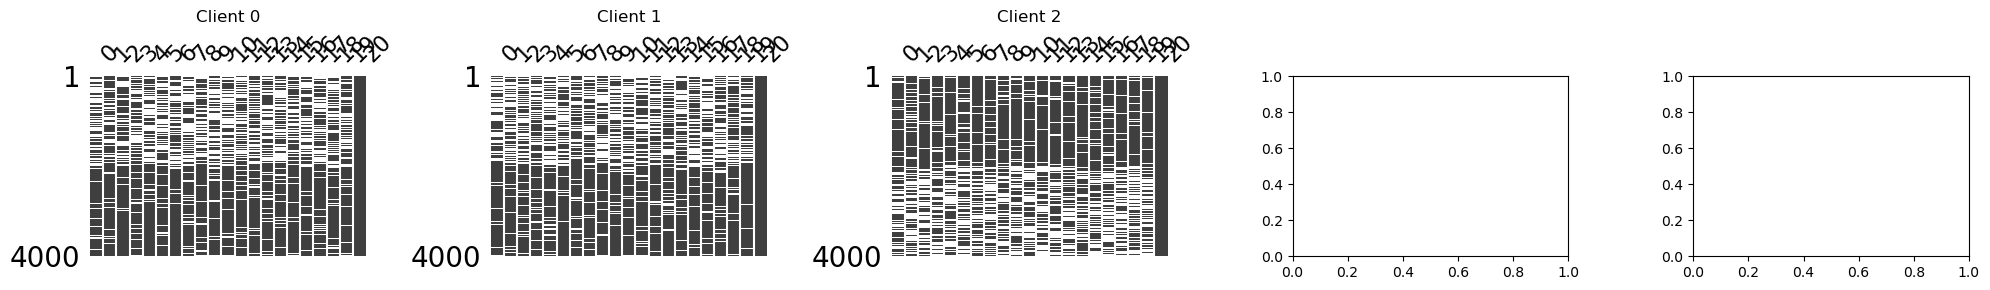

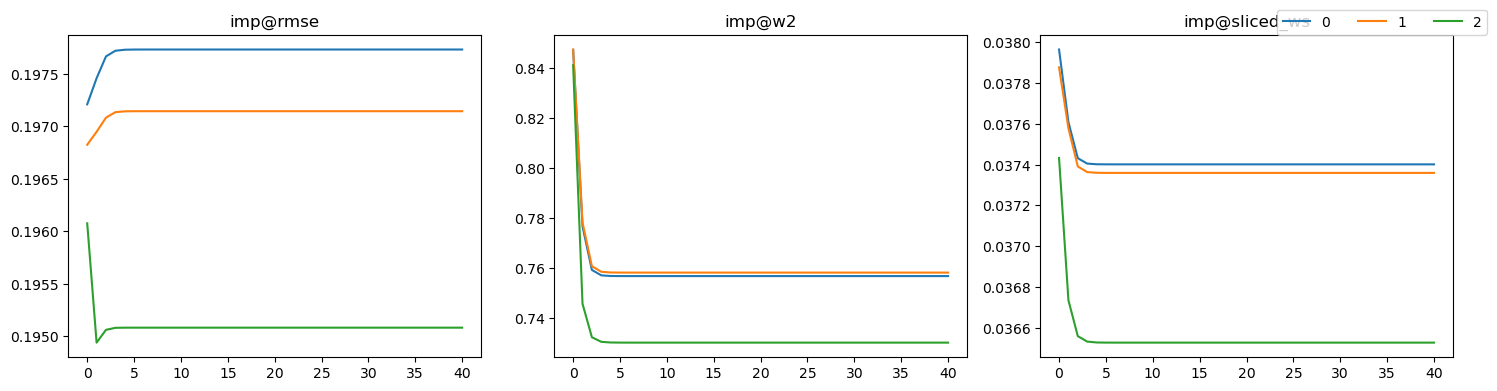

{'imp@rmse': 0.19665271724426808, 'imp@ws': 0.7484184059659343, 'imp@sliced_ws': 0.03709631540582075}


In [47]:
name = 'mary_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [48]:
pred_ret = NN_evaluation(
    rets['mary_lr21_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:49:23.383 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7859, test_f1: 0.7778, val_loss: 0.4559, val_accu: 0.7950, val_f1: 0.7950
2023-07-22 19:50:32.010 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7488, test_f1: 0.7335, val_loss: 0.4575, val_accu: 0.7908, val_f1: 0.7907
2023-07-22 19:51:39.699 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7480, test_f1: 0.7320, val_loss: 0.4577, val_accu: 0.7925, val_f1: 0.7923
2023-07-22 19:52:47.738 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7537, test_f1: 0.7388, val_loss: 0.4519, val_accu: 0.7937, val_f1: 0.7936
2023-07-22 19:53:56.077 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7629, test_f1: 0.749

0.8170301330196362


In [49]:
pred_ret = NN_evaluation(
    rets['mary_lr21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:59:38.221 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5364, train_loss: 0.6918 val_accu: 0.5446 val_f1: 0.4773
2023-07-22 20:00:02.860 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8899, train_loss: 0.4165 val_accu: 0.8150 val_f1: 0.8148
2023-07-22 20:00:28.103 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8830, train_loss: 0.4025 val_accu: 0.8221 val_f1: 0.8217
2023-07-22 20:00:53.455 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8897, train_loss: 0.3894 val_accu: 0.8275 val_f1: 0.8272
2023-07-22 20:01:18.870 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9059, train_loss: 0.3794 val_accu: 0.8333 val_f1: 0.8333


0.9207311555515338
